In [1]:
#helper libraries
import numpy as np
from numpy.random import rand
import math
import scipy.optimize
import matplotlib.pyplot as plt

#qiskit functionalities
from qiskit import Aer, execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram

#noise model stuff
from qiskit.providers.aer.noise import NoiseModel, kraus_error, pauli_error
    
#operator info
from qiskit.quantum_info import PauliList, Pauli, Kraus
from qiskit.circuit.library import XGate

Define the terms
$$
\vec\lambda, \kappa, K \equiv |\kappa|, \vec \omega
$$
Where $\vec \lambda$ is a list of the coefficients, $\kappa$ is the set of Pauli operators in the model, $K$ is the order of this set, and $\vec \omega$ is the transformed product-form coefficients in the noise model (Eq. S9)

In [2]:
n = 1 #Number of qubits (Later specify processor topology)
model_paulis = PauliList(['I', 'X', 'Y', 'Z'])
pauli_list = PauliList(['X', 'Y', 'Z']) #Kappa
K = len(pauli_list) #K = |Kappa|
coeffs = [.01, .05, .0085]

Eq. S9: $\omega_k = \frac{1}{2}(1+e^{-2\lambda_k})$

In [3]:
omegas = []
for (k, lambdak) in enumerate(coeffs):
    omegas.append(.5*(1+math.exp(-2*lambdak)))

Defining the simplectic inner product, a piecewise function such that
$$
\langle P_a, P_b \rangle_{sp} = 
\begin{cases}
0 & [P_a, P_b] = 0 \\
1 & \text{else}
\end{cases}
$$
This is expressed in a matrix $M_{ab} = \langle P_a, P_b \rangle_{sp}$ to simplify equation (S10)

In [4]:
#Symplectic inner product
def s_prod(a, b):
    if(a.compose(b) == b.compose(a)):
        return 0
    else:
        return 1

M = np.zeros([len(model_paulis),K])
for (i,a) in enumerate(model_paulis):
    for (j,b) in enumerate(pauli_list):
        M[i,j] = s_prod(a,b)
        

In [5]:
print(M)

[[0. 0. 0.]
 [0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]]


ideal_fidelities is the ideal $\vec f$ (with components $f_a$) giving the fidelities for each element in `pauli_list`. This is computed using Eq. (S11),
$$
-\log(\vec f)/2 = M\vec \lambda
$$

In [6]:
ideal_fidelities = np.exp(-2*np.dot(M, coeffs))
print(ideal_fidelities)

[1.         0.88958519 0.96367614 0.88692044]


This is an alternative expression of the noise model through Kraus operators according to Eq. (1):
$$
\Lambda(\rho) = \prod_{k \in \kappa} \left(\omega_k \rho + P_k \rho P_k\right)
$$
where the product symbol denotes composition

In [7]:
#Build list of Kraus Operators
kraus_ops = Kraus(np.identity(2**n))
for (P,omega,lambdak) in zip(pauli_list, omegas, coeffs):
   if lambdak != 0:
        op = Kraus([P.to_matrix()*np.sqrt(1-omega),np.sqrt(omega)*np.identity(2**n)])
        kraus_ops = kraus_ops.compose(op)

C:\Users\Ben\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\qiskit\quantum_info\operators\channel\kraus.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if isinstance(data, np.ndarray) or np.array(data).ndim == 2:


In [8]:
#Kraus error channel
kraus_error_channel = kraus_error(kraus_ops.data)
kraus_noise_model = NoiseModel()
kraus_noise_model.add_all_qubit_quantum_error(kraus_error_channel, ['id', 'rz', 'sx', 'h', 'rx'])
kraus_basis_gates = kraus_noise_model.basis_gates

I'm not sure whether the noise is dependent on the specific gates enacted. In the literature, it is written $\tilde{\mathcal{U}} = \mathcal{U} \circ \Lambda$, but is $\Lambda$ dependent on $\mathcal{U}$?

The pauli operators are diagonalizable in terms of their eigenvectors:
$$
P_a = \sum_{\vert\psi\rangle \in E_{a}(+1)} \vert\psi\rangle \langle\psi\vert - \sum_{\vert\psi\rangle\in E_a(-1)} \vert\psi\rangle\langle\psi\vert
$$
Take $X$ for example:
$$
\begin{align}
\text{Tr}[X\Lambda(X)] &= \text{Tr}[X\Lambda(\vert+\rangle\langle+\vert-\vert-\rangle \langle -\vert)]\\
&= \text{Tr}[X\Lambda(\vert+\rangle\langle+\vert)]+\text{Tr}[X\Lambda(\vert-\rangle\langle -\vert)]
\end{align}
$$

For $X$ estimation

In [9]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
backend = Aer.get_backend('qasm_simulator')

In [1]:
#The counts objects are annoyingly not dictionaries, so they don't have the has_key()
#method build in
def haskey(counts, key):
    return key in list(counts.keys())

#Get the expectation value from a counts object
def expectation(counts):
    if not haskey(counts, '0'):
        return -1
    if not haskey(counts, '1'):
        return 1
    return (counts['0']-counts['1'])/(counts['0']+counts['1'])

#Measure in one of the Pauli bases given an eigenvalue
def meas_basis(qc, qbit, cbit, basis):
    match basis:
        case '+':
            qc.h(qbit)
            qc.measure(qbit, cbit)
        case '-':
            qc.h(qbit)
            qc.measure(qbit, cbit)
        case 'r':
            qc.sdg(qbit)
            qc.h(qbit)
            qc.measure(qbit, cbit)
        case 'l':
            qc.sdg(qbit)
            qc.h(qbit)
            qc.measure(qbit, cbit)
        case '0':
            qc.measure(qbit,cbit)
        case '1':
            qc.measure(qbit,cbit)
        
#prepare eigenstate and generate a number of folds
def fold_state(eig, gate, folds):
    qc = QuantumCircuit(1,1)
    qc.initialize(eig)
    qc.barrier()
    for j in range(folds):
        qc.append(gate, [0])
        qc.barrier()
        qc.append(gate.inverse(), [0])
        qc.barrier()
    meas_basis(qc, 0, 0, eig)
    return qc

#Generate circuits for negative and positive eigenvalues and return as tuple
def bench_circuits(pos_eig, neg_eig, gate, folds):
    pos = fold_state(pos_eig, gate, folds)
    neg = fold_state(neg_eig, gate, folds)
    return [pos, neg]

#Reconstruct the expectation value on a Pauli operator given the expectation values
#on the positive and negative eigenstates
def reconstruct(positive, negative):
    return (1/2**n)*(positive-negative)

def measure_fidelity(pos_circuit, neg_circuit):
    job = execute(pos_circuit, backend, noise_model=kraus_noise_model,
                  basis_gates = kraus_basis_gates, shots = shots)
    pos = expectation(job.result().get_counts())
    job = execute(neg_circuit, backend, noise_model=kraus_noise_model, 
                  basis_gates = kraus_basis_gates, shots = shots)
    neg = expectation(job.result().get_counts())
    return reconstruct(pos, neg)

SyntaxError: invalid syntax (864323485.py, line 16)

In [20]:
gate = XGate() #the gate to use for noise profiling. Is the noise gate-dependent?
folds = 40 #number of folds to fit noise
shots = 4096
#X estimation
circuits = []
for i in range(folds):
    circuits.append(bench_circuits("+", "-", gate, i))

fidelities = []
for [pos_circ, neg_circ] in circuits:
    fidelities.append(measure_fidelity(pos_circ, neg_circ))

xfidelities = fidelities.copy()

#Y estimation
circuits = []
for i in range(folds):
    circuits.append(bench_circuits("r", "l", gate, i))

fidelities = []
for [pos_circ, neg_circ] in circuits:
    fidelities.append(measure_fidelity(pos_circ, neg_circ))

yfidelities = fidelities.copy()

#z estimation
circuits = []
for i in range(folds):
    circuits.append(bench_circuits("0", "1", gate, i))

fidelities = []
for [pos_circ, neg_circ] in circuits:
    fidelities.append(measure_fidelity(pos_circ, neg_circ))

zfidelities = fidelities.copy()

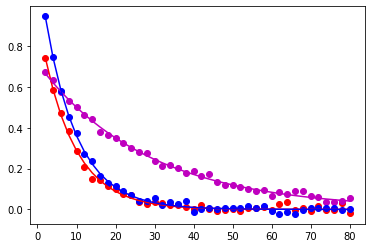

In [21]:
xrange = np.multiply(2,range(1,1+folds)) 

plt.plot(xrange, xfidelities, 'ro')
plt.plot(xrange, yfidelities, 'mo')
plt.plot(xrange, zfidelities, 'bo')

#perform optimized fit to extrapolate to the the single-gate noise limit


#do they decay to zero over time?
def Exp(t, b, a):
    return a*np.exp(-t * b)

p0 = (.05, 1)
params, cv = scipy.optimize.curve_fit(Exp, xrange, xfidelities, p0)
bx, ax = params
plt.plot(xrange, ax*np.exp(np.multiply(-1*bx, xrange)), 'r')

params, cv = scipy.optimize.curve_fit(Exp, xrange, yfidelities, p0)
by, ay = params
plt.plot(xrange, ay*np.exp(np.multiply(-1*by, xrange)), 'm')

params, cv = scipy.optimize.curve_fit(Exp, xrange, zfidelities, p0)
bz, az = params
plt.plot(xrange, az*np.exp(np.multiply(-1*bz, xrange)), 'b');

In [22]:
measured_fidelities = [1, math.exp(-bx), math.exp(-by), math.exp(-bz)]
print(measured_fidelities)
print(ideal_fidelities)

[1, 0.8883237588413975, 0.9648982363010735, 0.8867243879828367]
[1.         0.88958519 0.96367614 0.88692044]


Now, the coefficients in the Lindbladian are reconstructed using the sparse model

In [23]:
def lsq_fit(coeffs):
    return np.sum(np.dot(M,coeffs)+np.log(measured_fidelities)/2)

coeffs_guess = scipy.optimize.nnls(M, -.5*np.log(measured_fidelities))
measured_coeffs = coeffs_guess[0]
#Compare guess to the actual values
print(measured_coeffs)
print(coeffs)

[0.00938367 0.05072686 0.00848264]
[0.01, 0.05, 0.0085]


Now that the error model is learned, it can be reconstructed to do PEC, with the inverse
$$
\Lambda^{-1}(\rho) = \gamma\prod_{k\in \kappa}(\omega_k \rho - (1-\omega_k)P_k \rho P_k)
$$
The procedure as described in the text is as follows:
1. sample the identity with probability $\omega_k$ and sample the Pauli $P_k$ otherwise
2. record the number of times $m$ a Pauli was sampled
3. multiply the final result by $\gamma (-1)^m$
4. average the results together to get the mitigated expectation value

The overhead is given by
$$
\gamma = \exp(2\sum_k \lambda_k)
$$

In [24]:
samples = 10000 #number of circuits toi sample

overhead = np.exp(2*np.sum(coeffs)) #Compute the sampling overhead

ideal_circuit = QuantumCircuit(qr, cr)
ideal_circuit.x(0)
ideal_circuit.measure(0,0) #expectation value 
ideal_circuit.draw()

┌───┐┌─┐
  q0: ┤ X ├┤M├
      └───┘└╥┘
c0: 1/══════╩═
            0

In [25]:
job = execute(ideal_circuit, backend, noise_model = kraus_noise_model, basis_gates = kraus_basis_gates, shots=10000)
unmitigated_value = expectation(job.result().get_counts())
print(unmitigated_value)

-0.8924


Using the learned $\lambda_k$ model coefficients, calculate the $\omega_k$ for sampling

In [26]:
measured_omegas = np.exp(-2*np.dot(M, measured_coeffs))

Circuits are sampled into `circuits` according to the procedure

In [27]:
circuits = [] #Circuits sampled from distribution
ms = []
ideal_circuit = QuantumCircuit(qr, cr)
ideal_circuit.x(0)

#Follow the procedure for sampling gates
for i in range(samples):
    m = 0 #m keeps track of the sign, with paulis carrying a negative sign
    qc = ideal_circuit.copy()
    op = Pauli('I')
    for (omega, Pk) in zip(omegas, pauli_list):
        #with probability 1-\omega_k, sample the Pauli gate and compose into operator
        if rand() < 1-omega:
            m+=1
            op = op.compose(Pk) #Wow I spent so long on this silly line
    qc.barrier()
    qc.append(op.to_instruction(),[0])
    qc.barrier()
    qc.measure(0,0)
    circuits.append(qc)
    ms.append(m)

In [28]:
#run each circuit with a single shot and record the result
job = execute(circuits, backend, noise_model = kraus_noise_model, basis_gates = kraus_basis_gates, shots = 1)

In [29]:
total = 0
for (count,m) in zip(job.result().get_counts(),ms):
    total += expectation(count)*(-1)**m*overhead

mitigated_value = total/samples

In [30]:
print("overhead: ", overhead)
print("actual value: -1.0")
print("unmitigated value: ", unmitigated_value)
print("mitigated value: ", mitigated_value)

overhead:  1.1468281485203982
actual value: -1.0
unmitigated value:  -0.8924
mitigated value:  -0.9917769828403039
